## To do:
* Prepare the datasets and apply data cleaning.
* Preprocess the data using Scaling and Formatting.
* Specify the hyperparameters.
* fit the model and visualize.
## The visualizations and metrics:

### Visualizations:
* Learning Curve {Training vs. Validation}
* Confusion Matrix
* ROC Curve
* Precision-Recall Curve
* Qualitative Analysis
### Metrics:
#### For general learning curve comparisons:
* Classification report
* Accuracy_score
* F1_Score
* Recall
* Precision
* Matthew's Correlation Coefficient 
#### For Confusion Matrix:
* Macro-Average Specificity
* Hamming Loss
#### For ROC Curve:
* Area Under Curve
#### For Precision-Recall Curve:
* Average Precision

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from Temp import NeuralNetwork
import numpy as np


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X, y = X.astype(int), np.array(y, dtype=int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

scaler = StandardScaler()
pca = PCA(n_components=300) 

X_train_proc = scaler.fit_transform(X_train)
X_train_proc = pca.fit_transform(X_train_proc)
X_test_proc = pca.transform(scaler.transform(X_test))


param_grid = {      
    'eta': [0.01],         
    'batch_size': [128],           
    'max_iter': [2000],
    'activation': ['tanh'], 
}

model = NeuralNetwork(
    eta = 0.02,
    batch_size = 4096,
    max_iter = 2000,
    activation= 'relu',
    layers =[100, 50, 50], 
    
    early_stopping=True,
    tol=1e-4,
    patience=4,
    validation_fraction=0.1,
    verbose= 10,
    val_jump=10,
)

rs = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    n_iter=1,
    verbose=2,
    n_jobs=None 
)

# model = rs.fit(X_train_proc, y_train).best_estimator_
model = model.fit(X_train_proc, y_train)

epoch    0 loss 2.10153 - val_loss 2.04394
epoch   10 loss 0.69397 - val_loss 0.71490
epoch   20 loss 0.47873 - val_loss 0.50327
epoch   30 loss 0.40408 - val_loss 0.41848
epoch   40 loss 0.33562 - val_loss 0.37217
epoch   50 loss 0.30926 - val_loss 0.34166
epoch   60 loss 0.27890 - val_loss 0.31917
epoch   70 loss 0.25304 - val_loss 0.30191
epoch   80 loss 0.22703 - val_loss 0.28845
epoch   90 loss 0.20400 - val_loss 0.27760
epoch  100 loss 0.21862 - val_loss 0.26856
epoch  110 loss 0.21290 - val_loss 0.26094
epoch  120 loss 0.21830 - val_loss 0.25442
epoch  130 loss 0.17122 - val_loss 0.24857
epoch  140 loss 0.17848 - val_loss 0.24374
epoch  150 loss 0.15762 - val_loss 0.23907
epoch  160 loss 0.15960 - val_loss 0.23492
epoch  170 loss 0.15075 - val_loss 0.23119
epoch  180 loss 0.15015 - val_loss 0.22782
epoch  190 loss 0.13678 - val_loss 0.22446
epoch  200 loss 0.13402 - val_loss 0.22212
epoch  210 loss 0.13657 - val_loss 0.21912
epoch  220 loss 0.11775 - val_loss 0.21693
epoch  230 

In [14]:

# print(f"Best:\n{rs.best_params_}")

In [15]:
y_pred = model.predict(X_test_proc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2071
           1       0.98      0.98      0.98      2363
           2       0.95      0.95      0.95      2097
           3       0.95      0.95      0.95      2142
           4       0.96      0.96      0.96      2047
           5       0.95      0.95      0.95      1894
           6       0.96      0.97      0.97      2063
           7       0.96      0.96      0.96      2188
           8       0.94      0.94      0.94      2048
           9       0.95      0.95      0.95      2087

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000


In [16]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef 
y_pred = model.predict(X_test_proc)
perf =(f"\
    Multinomial Logistic Regression\
    \nAccuracy: [{accuracy_score(y_test, y_pred):.4f}], \
    Precision: [{precision_score(y_test, y_pred, average='weighted'):.4f}], \
    Recall: [{recall_score(y_test, y_pred,average='weighted'):.4f}], \
    F1: [{f1_score(y_test, y_pred,average='weighted'):.4f}], \
    MCC: [{matthews_corrcoef(y_test, y_pred):.4f}]")

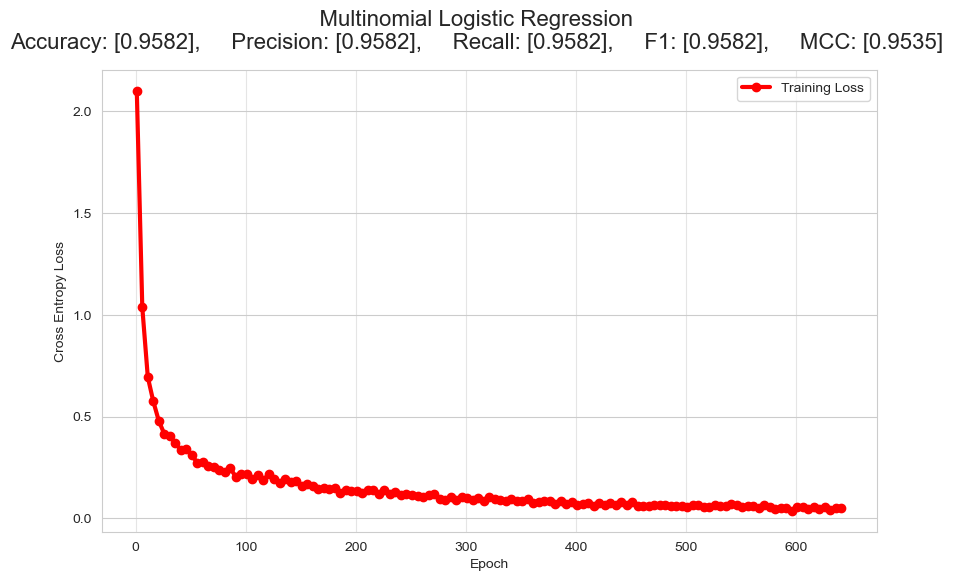

In [17]:
import numpy as np
import matplotlib.pyplot as plt

clf = model

scope = 5
fig, ax = plt.subplots(figsize=(10, 6))

if 'perf' in locals():
    fig.suptitle(perf, fontsize=16)

training_losses_cpu = [x.item() if hasattr(x, 'item') else x for x in clf.losses_]

t_x = np.arange(1, len(training_losses_cpu) + 1, scope)
t_y = training_losses_cpu[::scope]

if 0 < len(training_losses_cpu) != t_x[-1]:
    t_x = np.append(t_x, len(training_losses_cpu))
    t_y = np.append(t_y, training_losses_cpu[-1])

plot_data = [
    {
        "x": t_x,
        "y": t_y,
        "label": "Training Loss",
        "color": "red",
        "marker": "o"
    }
]

if hasattr(clf, 'val_losses') and len(clf.val_losses) > 0:
    losses_cpu = [x.item() if hasattr(x, 'item') else x for x in clf.val_losses]
    vscope=1
    v_x = np.arange(0, len(losses_cpu) *vscope,vscope)+1
    v_y = losses_cpu[::]
    
    if v_x[-1] != len(losses_cpu):
        v_x = np.append(v_x, len(losses_cpu)*vscope+1)
        v_y = np.append(v_y, losses_cpu[-1])

    min_val = np.min(losses_cpu)
    plot_data.append({
        "x": v_x,
        "y": v_y,
        "label": f"Validation Loss (Min: {min_val:.4f})",
        "color": "orange",
        "marker": "s"
    })

for data in plot_data:
    ax.plot(data["x"], data["y"], 
            label=data["label"], color=data["color"], marker=data["marker"], lw=3)


if hasattr(clf, "hist_"):
    hist = []
    for epoch, loss in clf.hist_:
        l = loss.item() if hasattr(loss, 'item') else loss
        hist.append([epoch, l])
    hist = np.array(hist)
    
    if hasattr(clf, "best_epoch_") and hist.ndim == 2 and hist.shape[0] > 0:
        ax.axvline(clf.best_epoch_, color='green', label=f'Best Epoch: {clf.best_epoch_}', linestyle='--', lw=2)
        ax.scatter(hist[:, 0], hist[:, 1], c="k", label="Improvement", marker='d', s=50, zorder=5, alpha=0.5)

ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.grid(axis="x", alpha=0.5)
ax.legend(loc="upper right")

plt.show()

Text(0.5, 38.72222222222221, 'Predicted Label')

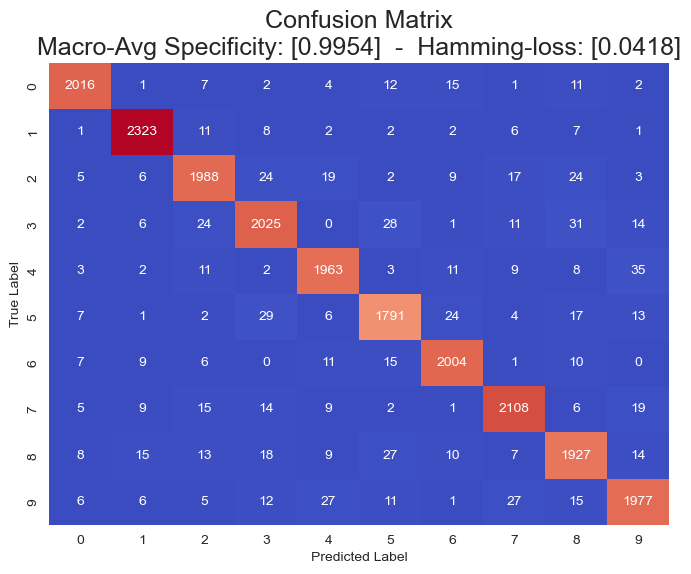

In [18]:
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, hamming_loss
cm = confusion_matrix(y_test, y_pred)
y_test_bin = label_binarize(y_test, classes=clf.classes_)
y_pred_bin = label_binarize(y_pred, classes=clf.classes_)

specs = []
for i in range(len(clf.classes_)):
    tn, fp, fn, tp = confusion_matrix(y_test_bin[:, i],y_pred_bin[:, i]).ravel()
    specs.append(tn / (tn + fp))
spec = np.mean(specs)
hamming = hamming_loss(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title(f'Confusion Matrix\nMacro-Avg Specificity: [{spec:.4f}]  -  Hamming-loss: [{hamming:.4f}]', fontsize=18)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


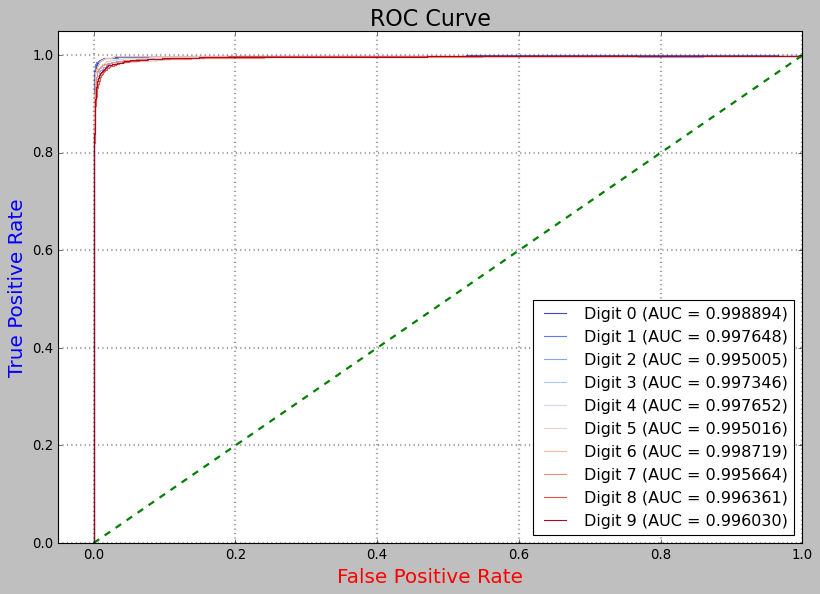

In [19]:
y_score = clf.predict_proba(X_test_proc)
n_classes = y_test_bin.shape[1]

with plt.style.context('classic'):
    plt.figure(figsize=(12, 8))
    colors = plt.get_cmap('coolwarm', n_classes)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors(i), lw=1, label=f'Digit {i} (AUC = {roc_auc:.6f})')
    plt.ylim(0, 1.05)
    plt.xlim(-0.05, 1.0)
    plt.plot([0, 1], [0, 1], 'g--',lw=2)
    plt.title('ROC Curve', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize =18, color='r')
    plt.ylabel('True Positive Rate', fontsize =18, color='b')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.4, axis="both",color ='k',lw=2)
    plt.show()

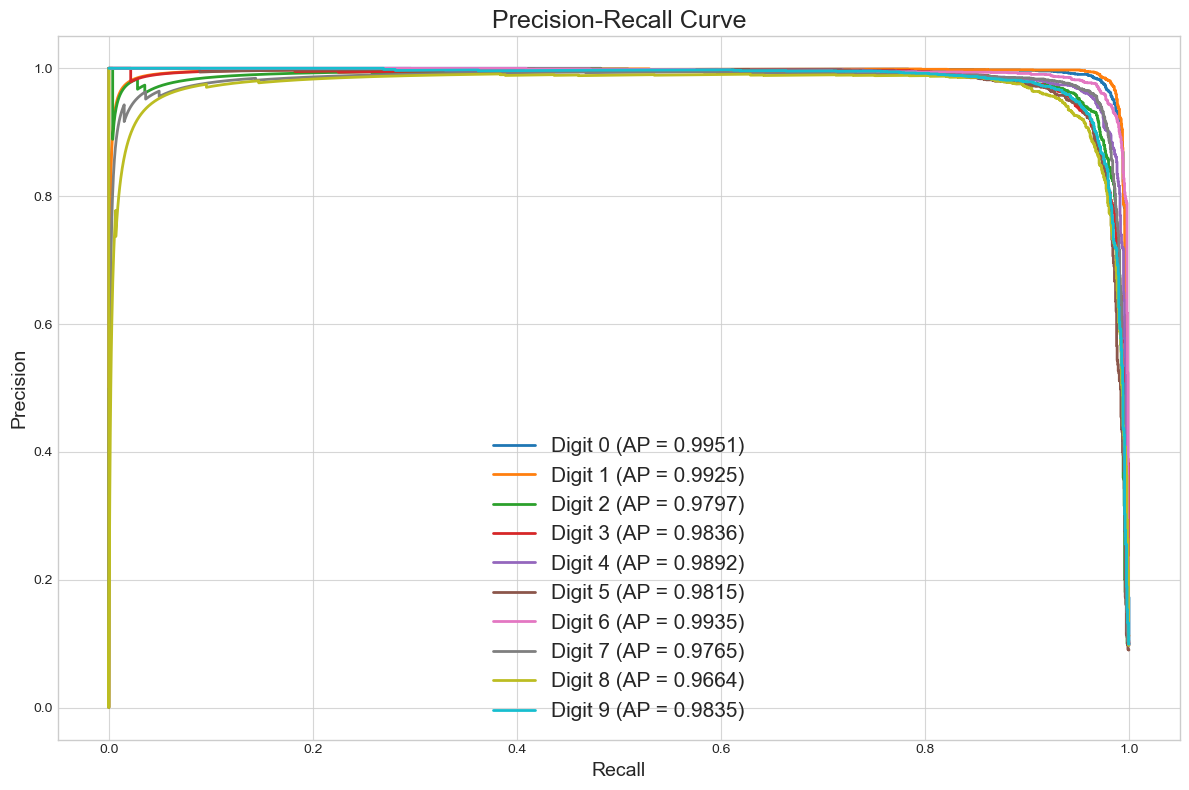

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score
y_score = clf.predict_proba(X_test_proc)
n_classes = y_test_bin.shape[1]


with plt.style.context('seaborn-v0_8-whitegrid'): 
    plt.figure(figsize=(12, 8))
    colors = plt.get_cmap('tab10', n_classes) 
    
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        prec = average_precision_score(y_test_bin[:, i], y_score[:, i])
        
        plt.plot(recall, precision, color=colors(i), lw=2,
                 label=f'Digit {i} (AP = {prec:.4f})')

    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve', fontsize=18)
    plt.legend(loc="best", fontsize=15) 
    plt.grid(alpha=0.8)
    plt.tight_layout()
    plt.show()

In [21]:
offset=0

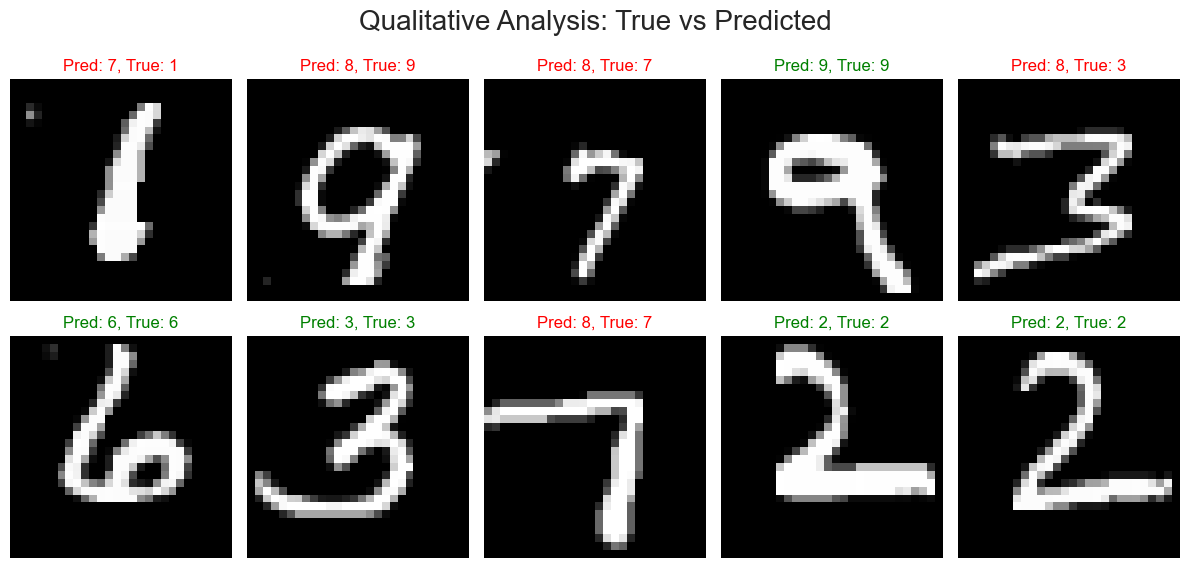

In [22]:
num_samples = 10
confidences = np.max(y_score, axis=1)
# indices = np.random.choice(len(X_test_proc), num_samples, replace=False) # random sample
indices = np.argsort(confidences)[::-1][offset:offset +num_samples] # most confidence predictions 
# indices = np.argsort(confidences)[offset:offset +num_samples] # least confidence predictions 
offset += num_samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Qualitative Analysis: True vs Predicted', fontsize=20)
for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = X_test[idx].reshape(28, 28)

    pred = model.predict(X_test_proc[idx].reshape(1, -1))[0]
    true = y_test[idx]

    ax.imshow(img, cmap='grey')
    ax.set_title(f"Pred: {pred}, True: {true}",
                 color=('green' if pred == true else 'red'))
    ax.axis('off')

plt.tight_layout()
plt.show()